In [ ]:
%matplotlib inline

## Audio Processing, Video Processing and Computer Vision
## Bachelor in Data Science and Engineering - Universidad Carlos III de Madrid

# LAB SESSION 4: IMAGE CLASSIFICATION WITH CNNs

# AUTOMATIC DIAGNOSTIC SYSTEM OF SKIN LESIONS FROM DERMOSCOPIC IMAGES


### Iván González Díaz, Miguel Ángel Fernández Torres


<center><img src='http://www.tsc.uc3m.es/~igonzalez/images/logo_uc3m_foot.jpg' width=400 /></center>

In this practice we are going to build a skin lesion diagnosis system based on dermoscopic image analysis.

## Part 0: The problem

Before starting the practice, we will briefly describe the database that we will use and the problem we aim to address:

Our goal is to develop a CNN providing an automatic diagnosis of cutaneous diseases from dermoscopic images. Dermoscopy is a non-invasive technique that allows the evaluation of the colors and microstructures of the epidermis, the dermoepidermal joint and the papillary dermis that are not visible to the naked eye. These structures are specifically correlated with histological properties of the lesions. Identifying specific visual patterns related to color distribution or dermoscopic structures can help dermatologists decide the malignancy of a pigmented lesion. The use of this technique provides a great help to the experts to support their diagnosis. However, the complexity of its analysis limits its application to experienced clinicians or dermatologists.

In our scenario, we will consider 3 classes of skin lesions:

- Malignant melanoma: Melanoma, also known as malignant melanoma, is the most common type of cancer, and arises from pigmented cells known as melanocytes. Melanomas typically occur on the skin and rarely elsewhere such as the mouth, intestines, or eye.

- Seborrheic keratosis: it is a noncancerous (benign) tumor of the skin that originates from the cells of the outer layer of the skin (keranocytes), so it is a non-melanocytic lesion.

- Benign nevus: a benign skin tumor caused by melanocytes (it is melanocytic)

Figure 1 shows a visual example of the 3 considered lesions:

![Image of ISIC](https://www.tsc.uc3m.es/~igonzalez/images/ISIC.jpg)

The dataset has been obtained from the 'Internatial Skin Imaging Collaboration' (ISIC) file. It contains 2750 images divided into 3 sets:
- Training set: 2000 images
- Validation set: 150 images
- Test set: 600 images

For each clinical case, two images are available:
- The dermoscopic image of the lesion (in the ‘images’ folder).
- A binary mask with the segmentation between injury (mole) and skin (in the 'masks' folder)

Additionally, there is a csv file for each dataset (training, validation and test) in which each lines corresponds with a clinical case, defined with two fields separated by commas:
- the numerical id of the lesion: that allows to build the paths to the image and mask.
- the lesion label: available only for training and validation, being an integer between 0 and 2: 0: benign nevus, 1: malignant melanoma, 2: seborrheic keratosis. In the case of the test set, labels are not available (their value is -1).

Students will be able to use the training and validation sets to build their solutions and finally provide the scores associated with the test set. This practice provides a guideliness to build a baseline reference system. To do so, we will learn two fundamental procedures:

- 1) Process your own database with pytorch
- 2) Design a feedforward CNN that processess images and provides a diagnostic
- 2) Use a regular network that has been pretrained using a large-scale general purpose dataset and fine-tune it for our diagnostic problem

## Part 1: Handling our custom dataset with PyTorch
Now we are going to study how we can load and process our custom dataset in pytorch. For that end, we are going to use the package ``scikit-image`` for reading images, and the package ``panda`` for reading csv files.


In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.enabled = False

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


The first thing we need to do is to download and decompress the dataset on a local folder:




In [4]:
#ONLY TO USE GOOGLE COLAB. Run this code only the first time you run this notebook and then comment these lines
from shutil import copyfile
from google.colab import drive
import os, sys
drive.mount('/content/drive')
copyfile('/content/drive/My Drive/LS4_AVCV_DB.zip', './LS4_AVCV_DB.zip') #Copy db files to our working folder

Mounted at /content/drive


IsADirectoryError: [Errno 21] Is a directory: '/content/drive/My Drive/LS4_AVCV_DB.zip'

In [3]:
#NOTE: Run this only once, in the machine where you want to run your code, then comment these lines
import zipfile
zipPath='./LS4_AVCV_DB.zip' #path of the 1st zip file
dataFolder='./data' #We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)

FileNotFoundError: [Errno 2] No such file or directory: './LS4_AVCV_DB.zip'

Now let's read the indexed file and display data from image 65. The file structure is one row per image of the database, and two fields:
- Image ID (a 4-digit sequence, adding 0 to the left side if required)
- Label: 0 benign nevus, 1 melanoma, 2 seborrheic keratosis



In [ ]:
db = pd.read_csv('data/LS4_AVCV_DB/dermoscopyDBtrain.csv',header=0,dtype={'id': str, 'label': int})

#We show inform
n = 65
img_id = db.id[65]
label = db.label[65]


print('Image ID: {}'.format(img_id))
print('Label: {}'.format(label))


Image ID: 0066
Label: 0


Now, let's create a simple function to show an image.




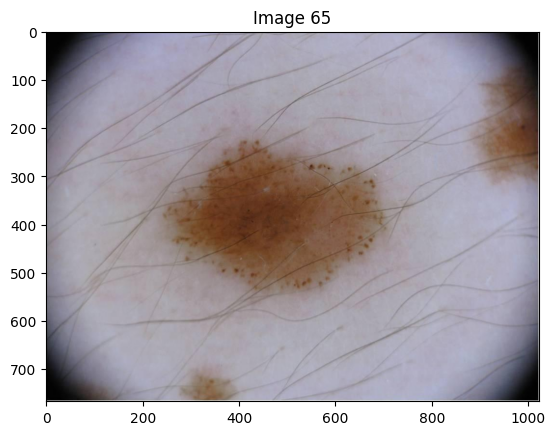

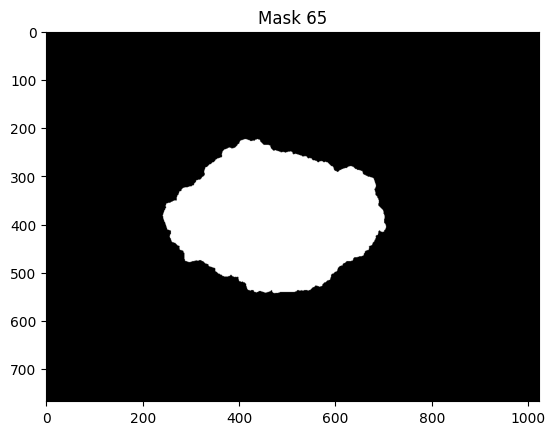

In [ ]:
def imshow(image, title_str):
    if len(image.shape)>2:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap=plt.cm.gray)
    plt.title(title_str)

plt.figure()
imshow(io.imread(os.path.join('data/LS4_AVCV_DB/images/', img_id + '.jpg' )),'Image %d'%n)
plt.figure()
imshow(io.imread(os.path.join('data/LS4_AVCV_DB/masks/', img_id + '.png')),'Mask %d'%n)

plt.show()

### Class Dataset

The class `` torch.utils.data.Dataset`` is an abstract class that represents a dataset.

To create our custom dataset in pytorch we must inherit from this class and overwrite the following methods:

- `` __len__`` so that `` len (dataset) `` returns the size of the dataset.
- `` __getitem__`` to support indexing `` dataset [i] `` when referring to sample $i$

We are going to create the train and test datasets of our diagnostic problem. We will read the csv in the initialization method `` __init__`` but we will leave the explicit reading of the images for the method
`` __getitem__``. This approach is more efficient in memory because all the images are not loaded in memory at first, but are read individually when necessary.

Our dataset is going to be a dictionary `` {'image': image, 'mask': mask, 'label': label} ``. You can also take an optional `` transform '' argument so that we can add pre-processing and data augmentation techniques.



In [ ]:
class DermoscopyDataset(Dataset):
    """Dermoscopy dataset."""

    def __init__(self, csv_file, root_dir,transform=None,  maxSize=0):
        """
        Args:
            csv_file (string): Path al fichero csv con las anotaciones.
            root_dir (string): Directorio raíz donde encontraremos las carpetas 'images' y 'masks' .
            transform (callable, optional): Transformaciones opcionales a realizar sobre las imágenes.
        """
        self.dataset = pd.read_csv(csv_file,header=0,dtype={'id': str, 'label': int})

        if maxSize>0:
            newDatasetSize=maxSize #maxSize muestras
            idx=np.random.RandomState(seed=42).permutation(range(len(self.dataset)))
            reduced_dataset=self.dataset.iloc[idx[0:newDatasetSize]]
            self.dataset=reduced_dataset.reset_index(drop=True)

        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir,'images')
        self.mask_dir = os.path.join(root_dir,'masks')
        self.transform = transform
        self.classes = ['nevus', 'melanoma', 'keratosis']
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Leemos la imagen
        img_name = os.path.join(self.img_dir,self.dataset.id[idx] + '.jpg')
        image = io.imread(img_name)
        #Leemos la máscara
        mask_name = os.path.join(self.mask_dir,self.dataset.id[idx] + '.png')
        mask = io.imread(mask_name)

        sample = {'image': image, 'mask': mask, 'label':  self.dataset.label[idx].astype(dtype=np.long)}
        if self.transform:
            sample = self.transform(sample)
        return sample

We now instantiate the class to iterate over some samples to see what we generate.


0 (767, 1022, 3) 0
1 (767, 1022, 3) 0
2 (767, 1022, 3) 1
3 (767, 1022, 3) 0


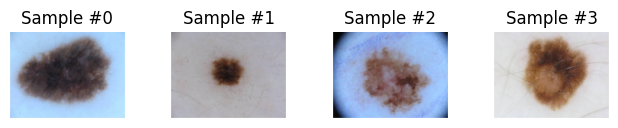

In [ ]:
train_dataset = DermoscopyDataset(csv_file='data/LS4_AVCV_DB/dermoscopyDBtrain.csv',
                                    root_dir='data/LS4_AVCV_DB')

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

**IMPORTANT**

The optional parameter ``maxSize`` in the constructor allows us to subsample the number of images and consequently reduce the size of the dataset. If not set included or maxSize=0, then the dataset will include all the images. This parameter is useful to train models over smaller datasets during hyperparameter validation and design phases. Working with less images reduces the training time at the expense of obtaining results that may deviate from those obtained with the full dataset size. Of course, the larger the training dataset, the more stable results but the larger the training time. Hence, it is up to the students the use of this parameter.

### Data Pre-Processing and Augmentation: Transforms
----------

In the previously shown examples we can see that the size of the images is not the same. This would prevent to train a red convolutional neuronal, as the vast majority require fixed-size inputs. Furthermore, the image is not always adjusted to the lesion, and indeed, in some examples lesions are very small compared to the size of the image. It would then be desirable to adjust the input images so that the lesion covers almost the entire image.

To do this, we are going to create some preprocessing code, focusing on 5 transformations:

- ``CropByMask``: to crop the image using the lesion mask
- ``Rescale``: to scale the image
- ``RandomCrop``: to crop the image randomly, it allows us to augment the data samples with random crops
- ``CenterCrop``: to perform a central crop of the image with the indicated size (useful in test)
- ``ToTensor``: to convert numpy matrices into torch tensors (rearranging the axes).

We will define them as callable classes instead of simple functions, as we will not need to pass the transform  parameters every time we call a method. To do this, we only have to implement the `` __call__`` method and, if necessary, the `` __init__`` method.
Then we can use a transformation with the following code:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)


In [ ]:
class CropByMask(object):
    """Crop the image using the lesion mask.

    Args:
        border (tuple or int): Border surrounding the mask. We dilate the mask as the skin surrounding
        the lesion is important for dermatologists.
        If it is a tuple, then it is (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        #Compute the coordinates of the bounding box that contains the mask
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Crop the image
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        return {'image': image, 'mask': mask, 'label' : label}

class Rescale(object):
    """Re-scale image to a predefined size.

    Args:
        output_size (tuple or int): The desired size. If it is a tuple, output is the output_size.
        If it is an int, the smallest dimension will be the output_size
            a we will keep fixed the original aspect ratio.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))

        return {'image': img, 'mask': msk, 'label' : label}

class RandomCrop(object):
    """Randomly crop the image.

    Args:
        output_size (tuple or int): Crop size. If  int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        if h>new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top=0

        if w>new_w:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}

class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w

        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0

        if w>new_w:
            left = int(rem_w/2)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}


class ToTensor(object):
    """Convert ndarrays into pytorch tensors."""

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        # Cambiamos los ejes
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        # A la máscara le añadimos una dim fake al principio
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)
        label=torch.tensor(label,dtype=torch.long)

        return {'image':image,
                'mask':mask,
                'label':label}

class Normalize(object):
    """Normalize data by subtracting means and dividing by standard deviations.

    Args:
        mean_vec: Vector with means.
        std_vec: Vector with standard deviations.
    """

    def __init__(self, mean,std):

        assert len(mean)==len(std),'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        c, h, w = image.shape
        assert c==len(self.mean), 'Length of mean and image is not the same'
        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        image.sub_(mean[:, None, None]).div_(std[:, None, None])


        return {'image': image, 'mask': mask, 'label' : label}

### Exercise:

Use the following code to apply the previous transforms and experiment with the values of the parameters to study their influence. Read the documentation at the begining of each class to understand the sintaxis of the input parameters.



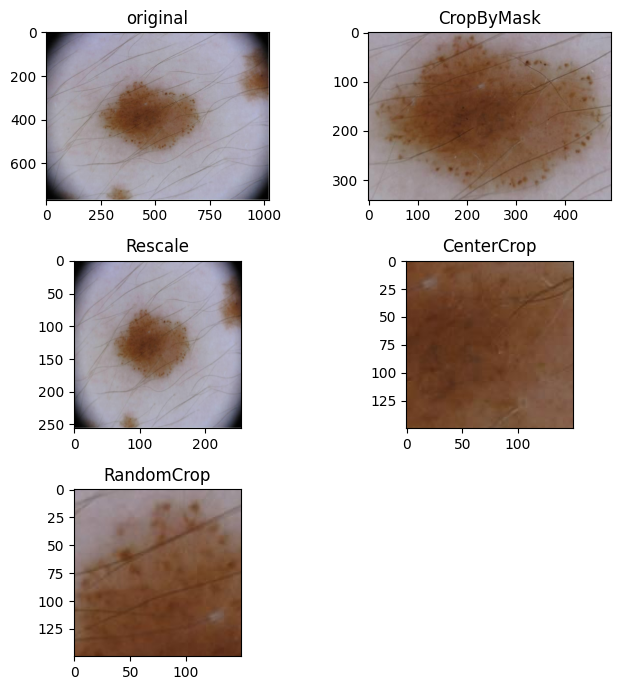

In [ ]:
### Modify this code to make your experiments....

# amount of skin around the lesion
cmask = CropByMask((5, 15))

# scales the image
scale = Rescale((256, 256))

# data augmentation
rcrop = RandomCrop(150)

# crops at the center
ccrop = CenterCrop(150)

# Apply each of the above transforms on sample.
fig = plt.figure(figsize=(7,7))
sample = train_dataset[65]
ax = plt.subplot(3,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

for i, tsfrm in enumerate([cmask, scale, ccrop, rcrop]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(3, 2, i+2)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'])

plt.show()

#### Using package torchvision.transforms

Package torchvision.trasforms comes with many useful methods that implement valuable transforms for data augmentation. Those transforms can be applied either to torch.tensors or to images. However, torchvision uses PIL library to read and process images, in contrast to the matrix representation of images used in scikit-image library (the library we have used in the previous methods). Furthermore, some of the transforms affect both to input images and skin-lesion masks, which avoid applying them to our samples. Hence, in order to use a torchvision transform we need to implement a pipeline that:

- 1) First, convert the matrix-based images to PILImages
- 2) Apply the transform to PILImages
- 3) Convert PILImages to matrices

And applies these to input images and, if necessary, to the binary skin-lesion masks. The following class ``TVCenterCrop`` implements the same functionality as the previous ``CenterCrop``, but using the corresponding method in torchvision. It is therefore a useful example if you plan to make use of torchvision transforms.


In [ ]:
class TVCenterCrop(object):
    """Crop the central area of the image. Example using the method in torchvision. Requires to
    internally convert from skimage (numpy array) to PIL Image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, size):
        self.CC=transforms.CenterCrop(size)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        pil_image=Image.fromarray(util.img_as_ubyte(image))
        pil_image=self.CC(pil_image)
        image=util.img_as_float(np.asarray(pil_image))

        pil_mask=Image.fromarray(util.img_as_ubyte(mask))
        pil_mask=self.CC(pil_mask)
        mask=util.img_as_float(np.asarray(pil_mask))

        return {'image': image, 'mask': mask, 'label': label}

Now, we apply to transform to check the results

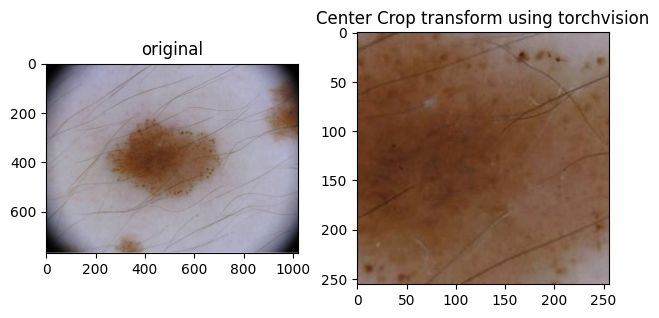

In [ ]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

tvcc=TVCenterCrop(256)

transformed_sample = tvcc(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Center Crop transform using torchvision')
plt.imshow(transformed_sample['image'])

plt.show()

### Exercise

Implement other transforms using torchvision package. Take TVCenterCrop as guide.


In [1]:
class TVRescale(object):
    """
    Re-scale image and mask using Resize from torchvision.

    Args:
        size (int or tuple):
            - int: resize so the shorter side == size
            - (H, W): resize to exact height & width
    """

    def __init__(self, size):self.size = size
        # Define interpolation modes

        # Bilinear because the image is a continuous signal and we want the new version to look smooth
        self.image_interp = InterpolationMode.BILINEAR

        # Nearest neighbour as the mask is categorical (values can only be 0 or 1)
        self.mask_interp = InterpolationMode.NEAREST

        # Resize transforms
        self.resize_image = transforms.Resize(size, interpolation=self.image_interp)
        self.resize_mask = transforms.Resize(size, interpolation=self.mask_interp)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']

        # We convert from Numpy to PIL images
        pil_image = Image.fromarray(util.img_as_ubyte(image))
        pil_mask  = Image.fromarray(util.img_as_ubyte(mask))

        # We apply the previous Resize transform to both
        pil_image = self.resize_image(pil_image)
        pil_mask  = self.resize_mask(pil_mask)

        # We convert back from PIL to Numpy
        image = util.img_as_float(np.asarray(pil_image))
        mask  = util.img_as_float(np.asarray(pil_mask))

        # We return the sample once it is already transformed
        return {'image': image, 'mask': mask, 'label': label}




IndentationError: unexpected indent (ipython-input-284319521.py, line 15)

### Composed Transforms

Now let's apply the different transformations to our images.

We will rescale the images so that their smallest dimension is 224 and then make random crops of size 224. To compose the transformations ``Rescale`` and ``RandomCrop`` we can use ``torchvision.transforms.Compose``, which is a simple callable class.


In [ ]:
composed = transforms.Compose([CropByMask(15), Rescale(224),RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

transformed_sample = composed(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Composed transform')
plt.imshow(transformed_sample['image'])

plt.show()

### Exercise:

Use the previous code to test different combinations of transform and discuss the results.

### Exercise:

Data augmentation techniques are useful as long as they model random transforms that may happen in the real world, and so can be found in test. Hence, the choice of the data augmentation techniques to be applied is problem-dependent and may differ from one dataset to another. Have a look at the images in the dataset and try to figure out which transforms are appropriate for these problem. Imagine how a dermatologist takes a dermoscopic picture and which factors may differ from one capture to another. Your results in the challenge will strongly depend on your design!!!!

In [ ]:
### Put your code here....






Iterating the dataset
-----------------------------

We can now put everything together to create the train and test datasets with the corresponding transformations.
In summary, every time we sample an image from the dataset (during training):
- We will read the image and the mask
- We will apply the transformations and we will crop the image using a bounding box computed from the mask
- As the final cropping operation is random, we perform data augmentation during sampling

We can easily iterate over the dataset with a ``for i in range`` loop.


In [ ]:
#Pixel means and stds expected by models in torchvision
pixel_mean=[0.485, 0.456, 0.406]
pixel_std=[0.229, 0.224, 0.225]

#Train Dataset
train_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtrain.csv',
                                    root_dir='data',
                                    maxSize=500, ###IMPORTANT: maxSize=500 to speed-up the training process
                                                 ### Set to 0 or 200 for training your optimal model
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    RandomCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))
#Val dataset
val_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBval.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

#Test dataset
test_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtest.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].size(), sample['label'])

    if i == 3:
        break

Finally, we have to create a dataloader allowing to:

- Sample batches of samples to feed the network during training
- Shuffle data
- Load the data in parallel using multiple cores.

``torch.utils.data.DataLoader`` is an iterator that provides all these features. An important parameter of the iterator is ``collate_fn``. We can specify how samples are organized in batches by choosing the most appropriate function. In any case, the default option should work fine in most cases.




In [ ]:
#Specify training dataset, with a batch size of 8, shuffle the samples, and parallelize with 3 workers
#IMPORTANT!!!!! If you plan to run this in a Windows machine, set num_workers=0. Pytorch has a bug on windows
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=3)
#Validation dataset => No shuffle
val_dataloader = DataLoader(val_dataset, batch_size=256,
                        shuffle=False, num_workers=3)

#Test Dataset => => No shuffle
test_dataloader = DataLoader(test_dataset, batch_size=256,
                        shuffle=False, num_workers=3)


# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Mostramos las lesiones de un batch."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    #Generamos el grid
    grid = utils.make_grid(images_batch)
    #Lo pasamos a numpy y lo desnormalizamos
    grid=grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])
    plt.figure()
    show_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()

    #We show the data of the 3rd batch and stop.
    if i_batch == 3:
        break

## Part 2: Design and train a custom diagnosis network
In the second part of the practice we are designing a diagnosis network from scratch. For that end, we next provide a definition of a network which is very similar to LeNet-5, which aims to classifiy input images of size 32x32 px containing digits (MNIST dataset with 10 classes). However, in this case, we are not forced to work with such small images and, indeed, it is highly recommended to user larger sizes (e.g. 224x224 px as it represents the standard size for most well-known networks trained in Imagenet).

In the following cell we provide the skeleton of a network called CustomNet, with the necessary methods: ` __init__` (constructor) and ``forward`` (forward method processes an image and provides a vector with the scores of the 10 classes considered in the problem of digit classification).


In [ ]:
#Example network
class CustomNet(nn.Module):
    def __init__(self):
        # In the constructor we will specify those processing blocks which require learnable parameters
        # We just define them to ensure persistence during training, although they will remain disconnected
        # until we define a processing pipeline in forward method.
        super(CustomNet, self).__init__()

        #2D convolution with 3 input channels, 16 output channels, and 5x5 filters
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Maxpooling with kernel 2x2
        self.pool = nn.MaxPool2d(2, 2)
        # 2D convolution with 16 input channels, 64 output channels, and 5x5 filters
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully-connected layer which expects an input with 16 channels and a spatial dimension of 5x5 (before flatenning)
        # and produces 120 channels at the output
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Fully-connected layer which expects an input of 120 channels and produces an output of 84 channels
        self.fc2 = nn.Linear(120, 84)
        # Fully-connected layer which expects an input of 84 channels and produces an output with 10 classes
        self.fc3 = nn.Linear(84, 10)

    #In forward method we connect layers and define the processing pipeline of the network
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #Flatten method vectorizes the spatial output of size hxwxchannels into a vector of length h*w*channels
        #by setting the parameter to 1, we start to flatten in dim=1 and do not vectorize the dimension representing
        #the images in the batch
        x = x.flatten(1)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)

        return x

#### Exercise:

Modify the previous network and define a CNN that processes a batch of images (e.g. of size 224x224) and computes their outputs with the scores for the 3 classes that we consider in our problem (nevus, melanoma and keratosis).

**IMPORTANT**: The structure of the network must be consistent in order to transform the input tensor  Nx3x224x224 (N the number of images in the batch, 3 the RGB channels, and 224 the spatial dimensions) into the tensor with the scores of each case, with size Nx3 (N the number of images in the batch and 3 the 3 classes of the problem). To do so, you have to adjust the architecture of the previous example, including the number of layers, the strides of each one, etc. so that it transforms the input tensor into the desired final vector. As an aid, the following code is provided that allows you to run the grid over a batch of images and see what the is shape of the output.

In [ ]:
customNet = CustomNet() #we initialize the network
customNet.to(device) #copy the network to the device (gpu)
#Sample a batch of data and get images and labels
data=next(iter(train_dataloader))
inputs = data['image'].to(device).float()
labels = data['label'].to(device)

batchSize = labels.shape
print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = customNet(inputs)
    print('Size of the output tensor is {}'.format(outputs.shape))



**Hint**: Start commenting all lines in the forward method in except of the first convolutional layer, execute the previous cell and and you will see the shape of the output of that layer. Go uncommenting layer by layer to see the sequential output sizes to decide how many convolutional layers may be adequate and the dimensions of the first fully convolutional layer.

## Part 3: Train and evaluate our CNN

In the third part of the practice we are going to build a first automatic system for the diagnosis of skin lesions based on the network that we have created in the previous section. To train and evaluate the network, we need to define several elements, such as the performance metric, the loss function, the optimizer or the learning rate strategy. In the next sections we will configure these elements.

### Performance Metric for evaluation
We will start by defining the metric we will use to evaluate our network. In particular, and following the instructions of the organizers of the original ISIC challenge, we will use the area under the ROC or AUC (https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

AUC is a metric that avoids setting a specific threshold to make detections and is applied over the soft outputs of a **binary** classifier. By modifying the value of the threshold, we can build a ROC curve setting the False Positive Rate (FPR) in the y-axis and the True Positive Rate (TPR) in the x-axis. TPR is the proportion of positive cases than have been succesfully detected, whereas FPR is the number of false detections divided by the number of negatives.

For low detection thresholds and an imperfect system, TPR will be high at the expense of a high FPR (as the system always says 1). For high threholds, the opposite situation happens. Once the ROC is built, the AUC measures the integral behind the curve, which is in the range [0,1].

Although, at least theoretically, AUC can be lower than 0.5, in partice, the output of a baseline system that randomly decides 0 or 1 with equal probability obtains an AUC=0.5, so lower values are usually caused by bugs in the code (and could be avoided just by inverting the outputs of the system).

The following figure shows some examples of AUC and ROC curves:


<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png' width=384 /></center>

As we have mentioned, AUC is a metric to evaluate binary problems (labels 0,1), and has the advantage of being independent of the detection threshold. It also behaves well against unbalanced problems, as it evaluates the ranking of the scores (their order with respect to the labels) and not their absolute values.

Since our problem is multiclass, we will calculate 3 different AUCs:
- 1) AUC of binary problem melanoma vs all
- 2) AUC of the binary problem seborrheic keratosis vs all
- 3) AUC average of the previous two

The following function computes AUCs from the complete database outputs:



In [ ]:
#Function that computes 2 AUCs: melanoma vs all and keratosis vs all
# scores is nx3: n is the number of samples in the dataset
# labels is nx1
# Function resturns an array with two elements: the auc values
def computeAUCs(scores,labels):

    aucs = np.zeros((2,))
    #Calculamos el AUC melanoma vs all
    scores_mel = scores[:,1]
    labels_mel = (labels == 1).astype(int)
    aucs[0]=metrics.roc_auc_score(labels_mel, scores_mel)

    #Calculamos el AUC queratosis vs all
    scores_sk = scores[:,2]
    labels_sk = (labels == 2).astype(int)
    aucs[1]=metrics.roc_auc_score(labels_sk, scores_sk)

    return aucs

### Loss function, optimizer, and learning rate strategy

In the next cell we will define the 3 elements we need to train:
- The loss function, which will be a crossed entreopia.
- The optimizer, in which we will use a SGD with momentum, with certain values of lr and momentum
- A learning rate strategy, using a fixed step method, decreasing the lr by a factor of 10, every 7 epochs.


In [ ]:
#Loss function
criterion = nn.CrossEntropyLoss()

# SGD with momentum
optimizer_ft = optim.SGD(customNet.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Training function

We continue by defining the function that we will use to train our classifier. Note the existence of 3 nested loops:
- Epoch loop: a main loop that goes through training epochs and then allows values to be taken from the evaluation metrics.
- Database loop: the train database is executed first, training the model, and then the validation database, only to obtain outputs and calculate evaluation metrics.
- Loop of iterations: in each iteration the forward, the evaluation of the loss, the backward and the updating of the weights in the optimizer are made.

In [ ]:
#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    numClasses = len(image_datasets['train'].classes)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_aucs = np.zeros((2,)) #AUCs melanoma vs all, and keratosis
    best_auc = 0
    best_epoch = -1

    #Loop of epochs (each iteration involves train and val datasets)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)



        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)


            #Dataset size
            numSamples = dataset_sizes[phase]

            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=float)
            labels_m=np.zeros((numSamples,),dtype=int)
            running_loss = 0.0

            contSamples=0

            # Iterate (loop of batches)
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device).float()
                labels = sample['label'].to(device)


                #Batch Size
                batchSize = labels.shape[0]

                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)

                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels
                outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batchSize]=labels.cpu().numpy()
                contSamples+=batchSize

            #At the end of an epoch, update the lr scheduler
            if phase == 'train':
                scheduler.step()

            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]

            #Compute the AUCs at the end of the epoch
            aucs=computeAUCs(outputs_m,labels_m)

            #And the Average AUC
            epoch_auc = aucs.mean()

            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Fine-tuning of a pre-trained CNN
Once we have defined the training and evaluation functions, we will fine-tune AlexNet CNN using our database. In addition, we define the loss, the optimizer and the lr scheduler:

### Specifying the data loaders
Now we are going to assign the dataloaders that we had previously to the arrays of train and val

In [ ]:
image_datasets = {'train' : train_dataset, 'val': val_dataset}

dataloaders = {'train' : train_dataloader, 'val': val_dataloader}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = image_datasets['train'].classes


### Train your custom network
Finally, we can train the network for several epochs and see the train and validation results.

In [ ]:
#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

customNet = train_model(customNet, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)

#### Exercise:

The current code trains the network for 5 epochs using SGD with momentum, with a learning rate strategy and an early stop strategy (taking the epoch that obtains the best results in validation). You can modify this setting by choosing other values ​​for parameters, optimizers, strategies, etc.


#### Exercise

The current code trains the network for 5 epochs and then returns the model that obtains the best results in validation (measured through the AUC). It could be necessary, in case the training times are long and you work with Google Colab (with limits on the duration of the session), to implement a save-and-resume strategy that allows you to train models through different sessions . You can find details on how to do it at:

https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

## Part 4: Fine-tuning a pre-trained model

Now, instead of training a CNN designed by us from the beginning, we are going to do a fine-tuning of a network that has previously been trained for another task. As seen in theory, this is usually a good alternative when there is not a large amount of data to train (in proportion to the parameters to be learned).

In particular, we are going to use the Alexnet CNN network, included in the ``torchvision`` package, with the weights that have been pre-trained in Imagenet.

The difference between both cases is that ImageNet has 1000 categories of objects and our database has 3 (nevus, melanoma and seborrheic keratosis). Therefore, we will be able to reuse the entire network except the last layer, where the dimensions will be different from our problem. Therefore, once we load the model, we will overwrite the last layer with a new one, with randomly initialized weights, that meets the dimensions of our database.


In [ ]:
# Load the model => With pretrained=True we load the optimal weights for ImageNet,
# a dataset that has 1000 object categories => We do fine-tuning for our problem with 3 clases
ftNet = models.alexnet(pretrained=True)
#Print model structure
print(ftNet)
#Get the number of features of the last hidden layer
num_ftrs = ftNet.classifier[6].in_features
# Adjust the last layer to produce scores for 3 classes
# Generate a new layer that substitutes the old one
num_classes = len(train_dataset.classes)
ftNet.classifier[6] = nn.Linear(num_ftrs,num_classes)
# Show again the structure of the model with the modifications
print(ftNet)
ftNet = ftNet.to(device)


### Re-define the optimizer for the new network
The previous one was used on the customNet parameters, so we have to define a new one on the new network.

In [ ]:
# SGD with momentum
optimizer_ft = optim.SGD(ftNet.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train

In [ ]:
#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

ftNet = train_model(ftNet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

#### Exercise

The current solution uses Alexnet pre-trained on ImageNet and then fine-tunes it for our particular problem. You can try other networks, many of which come pre-trained in the ``torchvision`` package. For this, it is always necessary to adapt the last layers to our database, generating 3-position outputs. You can find a guide at:

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In addition to the torchvision models, github and other repositories also have very competitive networks that could be useful.



## Part 5: Evaluation (Important)
The evaluation of this practice will be done through a challenge, for which the students will have to send the results based on the test data in two categories:

- 1) CUSTOM Category: The results on the test set of a custom network, created from scratch by the students. In this case, the complete code of the network must appear in cells of the notebook and it will not be possible to make use of external networks/packages or pre-trained models.

- 2) FINE-TUNING Category: The results on the test set of a network that has been previously initialized in another database (with fine-tuning). In this case, existing models in torchvision or even external networks can be used.

In addition, the final mark will depend both on the results in both categories and on the content of a brief report (1 side for the description, 1 side for extra material: tables, figures and references) where they will describe the most important aspects of the proposed solutions. The objective of this report is for the teacher to assess the developments/extensions/decisions made by the students when optimizing their system. You do not need to provide an absolute level of detail about the changes made, just list them and briefly discuss the purpose of the changes.

### Details of the material to send for evaluation:

One zip file will be uploaded per group with the following contents:

- Two .csv files with the test outputs of the models that have trained in the two categories. Each file will contain a matrix of size 600x3, 600 lesions and the 3 classes considered in the problem. The array should be provided in csv format (with 3 numbers per row separated by ','). Code to generate the outputs is provided later.

- The report as described above.

- The notebook that integrates the creation of both models so that the teacher can check how things have been implemented.

**The deadline for submission of your results + the report is Friday Oct 31 at 23:59.**


Next we provide some functions that allow to test the network and create the csv file with the outputs.


In [ ]:
### Code that generates the test matrix
def test_model(model):
    since = time.time()

    numClasses = len(test_dataset.classes)

    model.eval()   # Ponemos el modelo en modo evaluación

    #Tamaño del dataset
    numSamples = len(test_dataset)

    # Creamos las variables que almacenarán las salidas y las etiquetas
    outputs_m=np.zeros((numSamples,numClasses),dtype=np.float)
    labels_m=np.zeros((numSamples,),dtype=int)
    contSamples=0

    # Iteramos sobre los datos
    for sample in test_dataloader:
        inputs = sample['image'].to(device).float()


        #Tamaño del batch
        batchSize = inputs.shape[0]

        # Paso forward
        with torch.torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            #Aplicamos un softmax a la salida
            outputs=F.softmax(outputs.data,dim=1)
            outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
            contSamples+=batchSize


    return outputs_m

Running the previous function and obtaining the matrix with the scores (Nx3)

In [ ]:
outputs=test_model(ftNet)

And finally save the matrix into a csv file

In [ ]:
import csv

with open('output_test.csv', mode='w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',')
    csv_writer.writerows(outputs);

In [ ]:
print(outputs)